In [1]:
import numpy as np
import os
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# Count number of training and validation images by walking through directories
files_train = 0
files_validation = 0
cwd = os.getcwd()
folder = 'dataset/train'

# Loop through each subfolder (class) in training directory and count files
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_train += len(files)

# Loop through each subfolder (class) in test directory and count files
folder = 'dataset/test'

for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_validation += len(files)

# Print total number of images in training and validation sets
print(files_train, files_validation)


772 180


In [2]:
# Set image dimensions
img_width, img_height = 48, 48

# Define paths to training and validation data directories
train_data_dir = 'dataset/train'
validation_data_dir = 'dataset/test'

# Assign image counts to variables for training process
nb_train_sample = files_train
nb_validation_sample = files_validation

# Set training parameters
batch_size = 32
epochs = 35
num_classes = 3  # Total number of output classes: empty, occupied, wrong_parking


In [3]:
# Load the VGG16 model with pretrained ImageNet weights, excluding the top fully connected layers
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Display model layers (for reference/debug)
model.layers

# Freeze the first 10 layers to retain pre-trained features and avoid overfitting on small dataset
for layer in model.layers[:10]:
    layer.traiable = False  # (Note: 'traiable' is likely a typo for 'trainable')

# Add custom classification head: flattening and final Dense layer with softmax for multiclass classification
x = model.output
x = Flatten()(x)

# Output layer with softmax activation to predict probabilities across 3 classes
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model combining base VGG16 and the new classification head
model_final = Model(inputs=model.input, outputs=predictions)

# Compile the model using categorical crossentropy for multiclass classification and SGD optimizer
model_final.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
    metrics=['accuracy']
)

# Print out class folder names for confirmation
print("Train directories:", os.listdir('dataset/train'))
print("Test directories:", os.listdir('dataset/test'))


Train directories: ['empty', 'occupied', 'wrong_parking']
Test directories: ['empty', 'occupied', 'wrong_parking']


In [4]:
# Remove Jupyter-specific checkpoint folders from train and test directories if they exist
!rm -rf train/.ipynb_checkpoints

# Clean up test directory as well by removing .ipynb_checkpoints
!rm -rf test/.ipynb_checkpoints


'rm' is not recognized as an internal or external command,
operable program or batch file.


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# Define image augmentation configuration for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # Filling strategy for shifted pixels
    zoom_range=0.1,  # Random zoom within range
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    rotation_range=5  # Small random rotations
)

# Define similar augmentation for validation set (can help generalization)
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=5
)

# Create generator for training data that yields batches of augmented images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Multiclass classification
    classes=['empty', 'occupied', 'wrong_parking']  # Define class labels explicitly
)

# Create generator for validation data (with similar transformations)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['empty', 'occupied', 'wrong_parking']
)


Found 772 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [6]:
# Print the mapping of class names to numeric labels used internally by the generator
print(train_generator.class_indices)
print(validation_generator.class_indices)


{'empty': 0, 'occupied': 1, 'wrong_parking': 2}
{'empty': 0, 'occupied': 1, 'wrong_parking': 2}


In [7]:
# Recreate the classification head again (same as earlier) - may be redundant but included
x = model.output
x = Flatten()(x)

# Output dense layer for 3 classes
predictions = Dense(num_classes, activation='softmax')(x)

# Define model using VGG16 base + new classification layer
model_final = Model(inputs=model.input, outputs=predictions)

# Compile again with SGD optimizer and crossentropy loss
model_final.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
    metrics=['accuracy']
)


In [8]:
# Train the model on the training data and validate on validation data
history = model_final.fit(
    train_generator,  # Augmented training images
    steps_per_epoch=nb_train_sample//batch_size,  # Steps per epoch
    validation_steps=nb_validation_sample//batch_size,  # Validation steps
    epochs=epochs,  # Number of training epochs
    validation_data=validation_generator  # Validation data generator
)


Epoch 1/35
24/24 [==============================] - 16s 487ms/step - loss: 0.8719 - accuracy: 0.5716 - val_loss: 0.7829 - val_accuracy: 0.7563
Epoch 2/35
24/24 [==============================] - 2s 98ms/step - loss: 0.4436 - accuracy: 0.8689 - val_loss: 0.4193 - val_accuracy: 0.8375
Epoch 3/35
24/24 [==============================] - 7s 279ms/step - loss: 0.2255 - accuracy: 0.9297 - val_loss: 0.3264 - val_accuracy: 0.8687
Epoch 4/35
24/24 [==============================] - 13s 521ms/step - loss: 0.1482 - accuracy: 0.9486 - val_loss: 0.3026 - val_accuracy: 0.9000
Epoch 5/35
24/24 [==============================] - 5s 186ms/step - loss: 0.1281 - accuracy: 0.9622 - val_loss: 0.2516 - val_accuracy: 0.9000
Epoch 6/35
24/24 [==============================] - 2s 97ms/step - loss: 0.0946 - accuracy: 0.9770 - val_loss: 0.2214 - val_accuracy: 0.9000
Epoch 7/35
24/24 [==============================] - 6s 241ms/step - loss: 0.0739 - accuracy: 0.9824 - val_loss: 0.1741 - val_accuracy: 0.9250
Epoch 

In [9]:
# Display the training history object which contains loss and accuracy for each epoch
history.history


{'loss': [0.8719172477722168,
  0.4436362087726593,
  0.22545576095581055,
  0.14823178946971893,
  0.1280904859304428,
  0.09459283947944641,
  0.07388634234666824,
  0.0645289272069931,
  0.04830988869071007,
  0.04120911657810211,
  0.03643537685275078,
  0.05017921328544617,
  0.051143523305654526,
  0.027994345873594284,
  0.017354020848870277,
  0.02663205936551094,
  0.024206314235925674,
  0.04524252191185951,
  0.02342510223388672,
  0.01800677925348282,
  0.02139924466609955,
  0.014236089773476124,
  0.009501698426902294,
  0.015607092529535294,
  0.012561830691993237,
  0.006306507159024477,
  0.008115442469716072,
  0.009977546520531178,
  0.007053868845105171,
  0.007832407020032406,
  0.0033750939182937145,
  0.005956723820418119,
  0.009387747384607792,
  0.007289097178727388,
  0.00605364702641964],
 'accuracy': [0.5716215968132019,
  0.8689188957214355,
  0.929729700088501,
  0.9486486315727234,
  0.9621621370315552,
  0.9770269989967346,
  0.9824324250221252,
  0.979

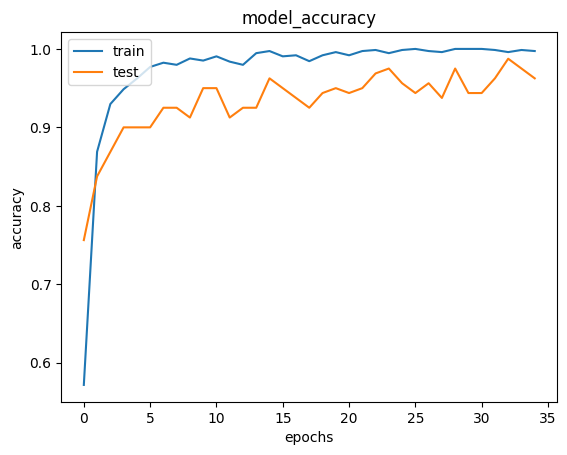

In [10]:
# Plot the training and validation accuracy over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])  # Training accuracy
plt.plot(history.history['val_accuracy'])  # Validation accuracy
plt.title('model_accuracy')  # Chart title
plt.ylabel('accuracy')  # Y-axis label
plt.xlabel('epochs')  # X-axis label
plt.legend(['train', 'test'], loc='upper left')  # Legend
plt.show()  # Display plot


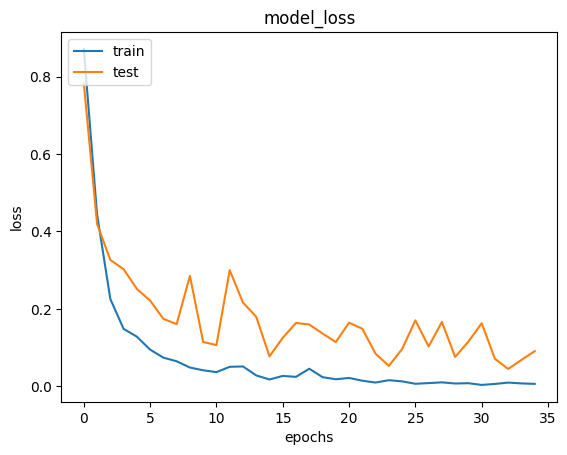

In [11]:
# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])  # Training loss
plt.plot(history.history['val_loss'])  # Validation loss
plt.title('model_loss')  # Chart title
plt.ylabel('loss')  # Y-axis label
plt.xlabel('epochs')  # X-axis label
plt.legend(['train', 'test'], loc='upper left')  # Legend
plt.show()  # Display plot


In [12]:
# Save the trained model in HDF5 format to disk
model_final.save('model_final.h5')


In [13]:
# Create a dictionary that maps class indices to human-readable labels
class_dictionary = {}
class_dictionary[0] = 'no_car'  # Class index 0
class_dictionary[1] = 'car'  # Class index 1
class_dictionary[2] = 'wrong_parking'  # Class index 2


In [14]:
# Print the class label dictionary
class_dictionary


{0: 'no_car', 1: 'car', 2: 'wrong_parking'}

In [15]:
# Save the trained model again (may be redundant but ensures persistence)
model_final.save("model_final.h5")
